# Connection to google drive

In [78]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## connect different python file to the notebook

In [79]:
import sys 
parentDir = F"/content/gdrive/MyDrive/final_project/orgnized_files!"
sys.path.append(parentDir)

In [80]:
from Helper_func import *

# Installations and data downloads

In [81]:
! mkdir -p ~/.kaggle;
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [82]:
!kaggle competitions download -c uw-madison-gi-tract-image-segmentation

uw-madison-gi-tract-image-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [83]:
!unzip /content/uw-madison-gi-tract-image-segmentation.zip

Archive:  /content/uw-madison-gi-tract-image-segmentation.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Imports

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


# EDA

## Exploring the segemention file

In [85]:
masks = pd.read_csv('train.csv')

In [86]:
masks.shape

(115488, 3)

In [87]:
masks

id        class segmentation
0       case123_day20_slice_0001  large_bowel          NaN
1       case123_day20_slice_0001  small_bowel          NaN
2       case123_day20_slice_0001      stomach          NaN
3       case123_day20_slice_0002  large_bowel          NaN
4       case123_day20_slice_0002  small_bowel          NaN
...                          ...          ...          ...
115483    case30_day0_slice_0143  small_bowel          NaN
115484    case30_day0_slice_0143      stomach          NaN
115485    case30_day0_slice_0144  large_bowel          NaN
115486    case30_day0_slice_0144  small_bowel          NaN
115487    case30_day0_slice_0144      stomach          NaN

[115488 rows x 3 columns]

## Integrity check 
Check that each id appears three times, according to the number of classes

In [88]:
masks['class'].value_counts()

large_bowel    38496
small_bowel    38496
stomach        38496
Name: class, dtype: int64

In [89]:
masks.id.duplicated().sum()

76992

In [90]:
masks['id'].value_counts().unique()

array([3])

## Basic statistic

In [91]:
masks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


We can see we have a lot of images that do not have all three classes. We want to check how many images we have in each class and how many images have in all three classes.

### Basic preprocessing
Allows easier presentation of statistics in data.

In [92]:
# Encode the class column - this encoding will help count the number of images for each class.
rank_dict = {'large_bowel':1, 'small_bowel':3, 'stomach':5}

masks['Encoded class'] = masks['class'].map(rank_dict)

masks[['class', 'Encoded class']]

class  Encoded class
0       large_bowel              1
1       small_bowel              3
2           stomach              5
3       large_bowel              1
4       small_bowel              3
...             ...            ...
115483  small_bowel              3
115484      stomach              5
115485  large_bowel              1
115486  small_bowel              3
115487      stomach              5

[115488 rows x 2 columns]

In [93]:
# split the id column to 3 columns
masks.id = masks.id.astype(str)
masks[['case_num','day_num','slice','scan_num']] = masks['id'].str.split('_',n=3, expand=True)
masks.drop(['slice'], axis = 1, inplace = True) 

In [94]:
masks.head(10)

id        class segmentation  Encoded class case_num  \
0  case123_day20_slice_0001  large_bowel          NaN              1  case123   
1  case123_day20_slice_0001  small_bowel          NaN              3  case123   
2  case123_day20_slice_0001      stomach          NaN              5  case123   
3  case123_day20_slice_0002  large_bowel          NaN              1  case123   
4  case123_day20_slice_0002  small_bowel          NaN              3  case123   
5  case123_day20_slice_0002      stomach          NaN              5  case123   
6  case123_day20_slice_0003  large_bowel          NaN              1  case123   
7  case123_day20_slice_0003  small_bowel          NaN              3  case123   
8  case123_day20_slice_0003      stomach          NaN              5  case123   
9  case123_day20_slice_0004  large_bowel          NaN              1  case123   

  day_num scan_num  
0   day20     0001  
1   day20     0001  
2   day20     0001  
3   day20     0002  
4   day20     0002  
5   day20     0002  
6   day20     0003  
7   day20     0003  
8   day20     0003  
9   day20     0004

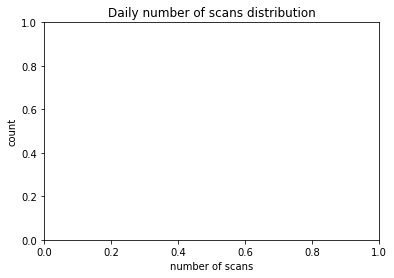

In [95]:
# Checking the number of scans per day of treatment
scans_per_day=(masks.groupby(by = ['case_num','day_num']).agg(number_of_scans = ('scan_num', 'count'))/3) #Dividing by three stems from the fact we have each id three times.
plt.title('Daily number of scans distribution')
plt.xlabel('number of scans');
plt.ylabel('count');

In [96]:
scans_per_day.value_counts()/scans_per_day.shape[0]

number_of_scans
144.0              0.945255
80.0               0.054745
dtype: float64

We can see that most days have 144 scans, but a few days with 80 scans.

### Dropna
Checking the statistics only for the images with the segmentation. 

In [97]:
masks_without_na = masks.dropna()

In [98]:
# Checking for each class how many images include in this class.
masks_without_na['class'].value_counts()

large_bowel    14085
small_bowel    11201
stomach         8627
Name: class, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


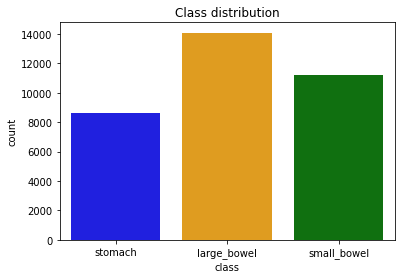

In [99]:
sns.countplot(masks_without_na['class'], palette=['blue','orange','green']);
plt.title('Class distribution');
plt.xlabel('class');

In [100]:
# Checking how many images with masks have 1/2/3 classes.
images_per_classes = masks_without_na.groupby(by = 'id').agg(number_of_classes = ('class', 'count')).value_counts().sort_index()
images_per_classes

number_of_classes
1                     2468
2                    10921
3                     3201
dtype: int64

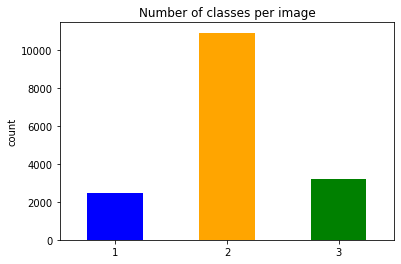

In [101]:
images_per_classes.index=[1,2,3]
images_per_classes.plot.bar(rot=0, color=['blue','orange','green'])
plt.ylabel("count")
plt.title("Number of classes per image");

In [102]:
numbaer_positive_samples = masks_without_na.groupby(by = 'id').agg(number_of_classes = ('class', 'count')).count()[0]
numbaer_positive_samples

16590

We can see that only 16590 images have segementation mask.

In [103]:
# Number of each combination of classes per image
masks_without_na.groupby(by = 'id').agg(number_of_classes = ('Encoded class', 'sum')).value_counts()

number_of_classes
4                    7781
9                    3201
6                    2980
5                    2286
8                     160
1                     123
3                      59
dtype: int64

1 class: 1 - large_bowel, 3 - small_bowel, 5 - stomach 

2 classes: 4 - large_bowel + small_bowel, 6 - large_bowel + stomach, 8 - small_bowel + stomach 

3 classes: 9 - all

check the distribution of days for each patient case and the distribution of scans per day

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


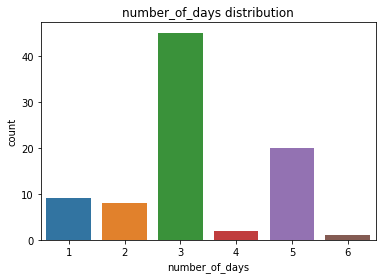

In [104]:
number_of_days = masks_without_na.groupby(by = ['case_num']).agg(number_of_days = ('day_num', 'nunique'))
# number_of_days
sns.countplot(number_of_days['number_of_days'])
plt.title('number_of_days distribution')
plt.xlabel('number_of_days');

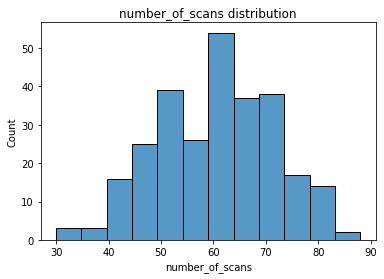

In [105]:
number_of_scans = masks_without_na.drop_duplicates(subset="id", keep='first').groupby(by = ['case_num','day_num']).agg(number_of_scans = ('scan_num', 'count'))
# number_of_scans
sns.histplot(number_of_scans['number_of_scans'])
plt.title('number_of_scans distribution')
plt.xlabel('number_of_scans');

In [106]:
masks_without_na.groupby(by = ['day_num']).agg(number_of_scans = ('scan_num', 'count')).shape

(35, 1)

In [107]:
masks.groupby(by = ['day_num']).agg(number_of_scans = ('scan_num', 'count')).shape

(35, 1)

We can see that we have segmentation mask for each patient and for each day.

## Exploring the images + segemention

### one image

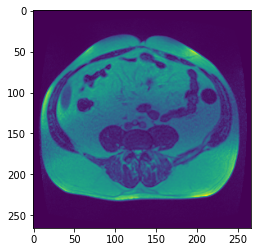

In [108]:
# using matplolib, the values in the image in the range [0,1]
path = '/content/train/case123/case123_day0/scans/slice_0111_266_266_1.50_1.50.png'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

(array([3.2495e+04, 7.0710e+03, 4.7630e+03, 6.8410e+03, 7.3890e+03,
        9.3530e+03, 2.1460e+03, 5.7300e+02, 9.9000e+01, 2.6000e+01]),
 array([0.        , 0.01159533, 0.02319066, 0.03478599, 0.04638132,
        0.05797665, 0.06957198, 0.08116731, 0.09276264, 0.10435797,
        0.1159533 ], dtype=float32),
 <a list of 10 Patch objects>)

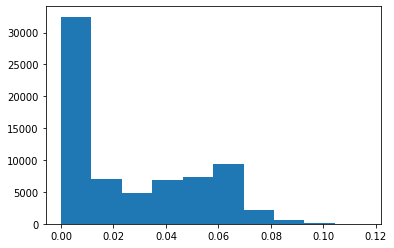

In [109]:
plt.hist(img.flatten())

We can see that the image is dark, and the distribution of the values is concentrated in a minimal range. We may want to change this before entering the image into the model.

In [110]:
img.shape

(266, 266)

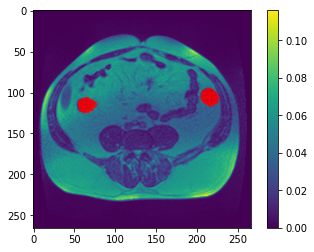

In [111]:
# Add the segemention on the image 
lis = masks[masks.id=="case123_day0_slice_0111"].segmentation.iloc[0]
lis = [int(i) for i in lis.split(" ")]
img_size = img.shape
img_seg = np.zeros_like(img)
imgplot_seg = plt.imshow(img)
plt.colorbar()
for pos in range(0,len(lis),2):
  # Converts a flat index or array of flat indices into a tuple of coordinate arrays.
  ezer = np.unravel_index(np.arange(lis[pos],lis[pos]+lis[pos+1]),img_size) 
  plt.scatter(ezer[1],ezer[0],s=0.1,c='r') # For visualization purpose only
  img_seg[ezer[0],ezer[1]] = [1] # Create the mask
plt.show()


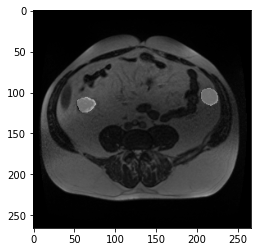

In [112]:
plt.imshow(img, cmap='gray')
plt.imshow(img_seg, alpha=0.4, cmap='gray')

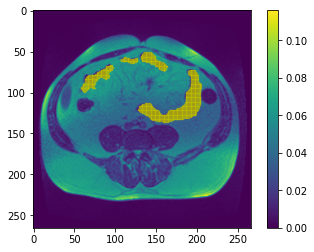

In [113]:
lis = masks[masks.id=="case123_day0_slice_0111"].segmentation.iloc[1]
lis = [int(i) for i in lis.split(" ")]
img_size = img.shape
img_seg = np.zeros_like(img)
imgplot_seg = plt.imshow(img)
plt.colorbar()
for pos in range(0,len(lis),2):
  ezer = np.unravel_index(np.arange(lis[pos],lis[pos]+lis[pos+1]),img_size)
  plt.scatter(ezer[1],ezer[0],s=0.1,c='y')
  img_seg[ezer[0],ezer[1]] = [2]
# img_seg = img_seg.reshape(img.shape)
plt.show()


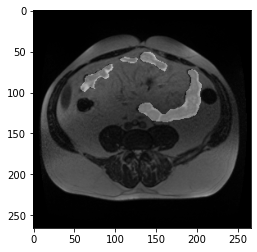

In [114]:
plt.imshow(img, cmap='gray')
plt.imshow(img_seg, alpha=0.4, cmap='gray')

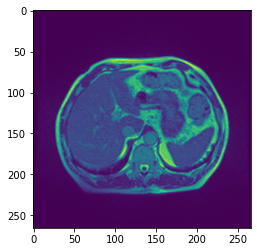

In [115]:
path = '/content/train/case149/case149_day0/scans/slice_0071_266_266_1.50_1.50.png'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

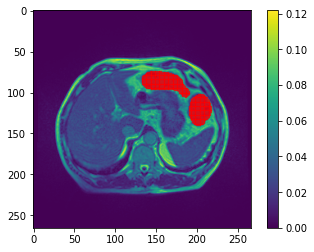

In [116]:
# Add the segemention on the image 
lis = masks[masks.id=="case149_day0_slice_0071"].segmentation.iloc[0]
lis = [int(i) for i in lis.split(" ")]
img_size = img.shape
img_seg = np.zeros_like(img)
imgplot_seg = plt.imshow(img)
plt.colorbar()
for pos in range(0,len(lis),2):
  # Converts a flat index or array of flat indices into a tuple of coordinate arrays.
  ezer = np.unravel_index(np.arange(lis[pos],lis[pos]+lis[pos+1]),img_size) 
  plt.scatter(ezer[1],ezer[0],s=0.1,c='r') # For visualization purpose only
  img_seg[ezer[0],ezer[1]] = [1] # Create the mask
plt.show()

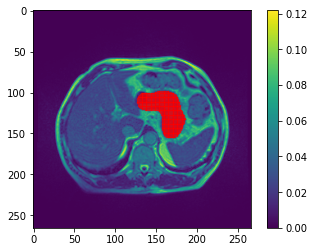

In [117]:
# Add the segemention on the image 
lis = masks[masks.id=="case149_day0_slice_0071"].segmentation.iloc[2]
lis = [int(i) for i in lis.split(" ")]
img_size = img.shape
img_seg = np.zeros_like(img)
imgplot_seg = plt.imshow(img)
plt.colorbar()
for pos in range(0,len(lis),2):
  # Converts a flat index or array of flat indices into a tuple of coordinate arrays.
  ezer = np.unravel_index(np.arange(lis[pos],lis[pos]+lis[pos+1]),img_size) 
  plt.scatter(ezer[1],ezer[0],s=0.1,c='r') # For visualization purpose only
  img_seg[ezer[0],ezer[1]] = [1] # Create the mask
plt.show()

### Go through all the images and check that they are not corrupt.

In [118]:
filelist = []
PATH = '/content/train/'

for root, dirs, files in os.walk(PATH):
	for file in files:
        #append the file name to the list
		filelist.append(os.path.join(root,file))
df_path = pd.DataFrame(sorted(filelist),columns=['path'])
df_path.head()

path
0  /content/train/case101/case101_day20/scans/sli...
1  /content/train/case101/case101_day20/scans/sli...
2  /content/train/case101/case101_day20/scans/sli...
3  /content/train/case101/case101_day20/scans/sli...
4  /content/train/case101/case101_day20/scans/sli...

In [119]:
print("No. of images = ", len(filelist))

No. of images =  38496


#### Split the path to id and the shape of the image

In [120]:
df_ezer = df_path.path.str.split('/', expand=True)
df_ezer.sample(1)

0        1      2       3            4      5  \
22148    content  train  case30  case30_day1  scans   

                                      6  
22148  slice_0133_266_266_1.50_1.50.png

In [121]:
df_ezer2 = df_ezer.loc[:,6].str.split('_', expand=True)
df_ezer2.sample(1)

0     1    2    3     4         5
11540  slice  0117  266  266  1.50  1.50.png

In [122]:
df_path.path = df_path.path.astype(str)
df_path['image_shape'] = list(zip(df_ezer2.loc[:,2],df_ezer2.loc[:,3]))

In [123]:
df_path['id'] = df_ezer.loc[:,4]+"_"+df_ezer2.loc[:,0]+"_"+df_ezer2.loc[:,1]

In [124]:
df_path.sample(1)

path image_shape  \
38442  /content/train/case92/case92_day0/scans/slice_...  (266, 266)   

                           id  
38442  case92_day0_slice_0091

In [125]:
df_path.describe()

path image_shape  \
count                                               38496       38496   
unique                                              38496           4   
top     /content/train/case101/case101_day20/scans/sli...  (266, 266)   
freq                                                    1       25920   

                              id  
count                      38496  
unique                     38496  
top     case101_day20_slice_0001  
freq                           1

We can see that not all the scans in the same size.

In [126]:
#  Table with the path of the image and the corresponding segmentation mask in RLE-format.
masks_paths = pd.merge(masks, df_path)
masks_paths.sample(1)

id        class segmentation  Encoded class  \
111669  case2_day3_slice_0024  large_bowel          NaN              1   

       case_num day_num scan_num  \
111669    case2    day3     0024   

                                                     path image_shape  
111669  /content/train/case2/case2_day3/scans/slice_00...  (266, 266)

In [127]:
#convert the day column to integer
masks_paths.day_num = masks_paths.day_num.astype(str)
masks_paths.day_num = masks_paths.day_num.apply(lambda word: (''.join(filter(lambda i: i.isdigit(), word)))).astype(int)
masks_paths.day_num.head()

0    20
1    20
2    20
3    20
4    20
Name: day_num, dtype: int64

In [128]:
# This file use in the next notebook
masks_paths.to_csv(parentDir+'/masks_paths.csv')

In [129]:
# Check how many images have for each size
dic={}
for i in range(df_path.shape[0]):
  if df_path.image_shape[i] in dic:
      dic[df_path.image_shape[i]] += 1
  else:
    dic[df_path.image_shape[i]] = 1
dic

{('234', '234'): 144,
 ('266', '266'): 25920,
 ('276', '276'): 1200,
 ('360', '310'): 11232}

In [130]:
# # Check the number of images in the different sizes for images with a mask.

# dic={}
# for i in range(df_path.shape[0]):
#   if (masks_without_na.id==df_path.id[i]).any():
#     if df_path.image_shape[i] in dic:
#       dic[df_path.image_shape[i]] += 1
#     else:
#       dic[df_path.image_shape[i]] = 1
# dic

## Look on images

In [133]:
image_gen = generator_images(masks_paths)

In [134]:
img, img_seg, id_img = next(image_gen)

In [135]:
classes = ['large_bowel','small_bowel','stomach','background']

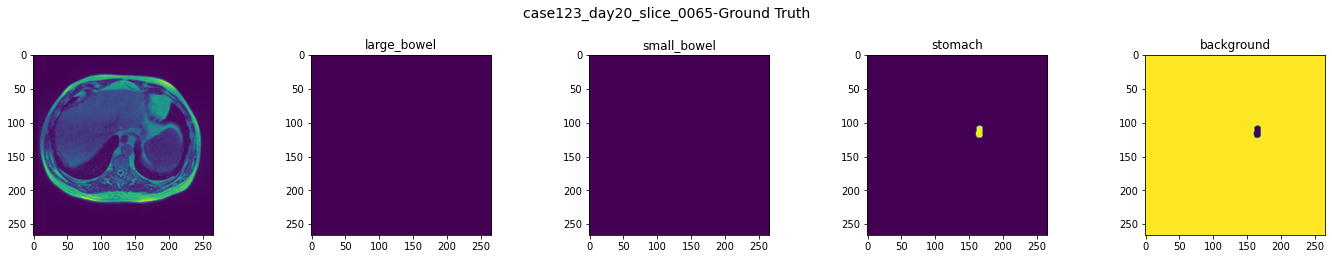

In [136]:
plot_image_mask(img[:,:,0],img_seg, id_img, classes)

In [137]:
image_gen = generator_images(masks_paths, flag=0)

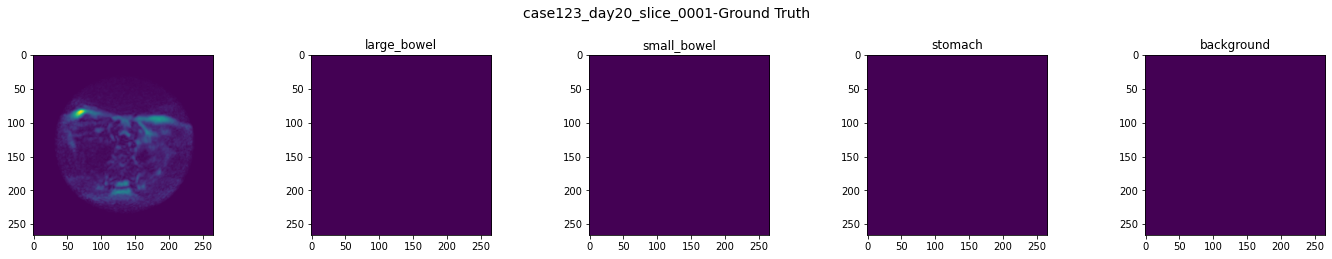

In [138]:
img, img_seg, id_img = next(image_gen)
plot_image_mask(img[:,:,0],img_seg, id_img, classes)